In [1]:
import stats_helpers as sh
import mpl_plotting_helpers as mph
import matplotlib.pyplot as plt

tab_colours = ["tab:blue", "tab:orange", "tab:green", "tab:red",
               "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.family'] = "sans-serif"

Loading the module: helpers.stats_helpers.py

Loading the module: helpers.general_helpers

numpy        1.19.2
scipy         1.7.2
pandas        1.2.3

Loading the module: helpers.mpl_plotting_helpers

Loading the module: helpers.pandas_helpers

Loading the module: helpers.argcheck_helpers

pandas        1.2.3
numpy         1.19.2

matplotlib    3.3.2
numpy         1.19.2



In [11]:
# Make dotplots
def add_errorbar(mpl_axes, x_pos, y_pos, 
                 std, color = "grey", x_offset = 0.05, 
                 transparency = 0.75):
    """
    Adds error bars to MatPlotLib axes object. Modifies the mpl_axes input, returns None.

    mpl_axes -> matplotlib axes object
    x_pos    -> position of the center of the error bars on the x axis
    y_pos    -> position of the center of the error bars on the y axis
    std      -> standard deviation of the data (or vertical offset for error bars)
    color    -> The color of the error bars (Default: "grey")
    x_offset -> Size of the middle of the error bars (Default: 0.05)
    """
    # Plot the vertical middle bar
    mpl_axes.plot([x_pos, x_pos], [y_pos + std, y_pos - std], color = color, alpha = transparency)
    # Plot the horizontal middle bar
    mpl_axes.plot([x_pos - x_offset, x_pos + x_offset], [y_pos, y_pos], color = color, alpha = transparency)
    # Plot the horizontal top bar
    mpl_axes.plot([x_pos - 0.75*x_offset, x_pos + 0.75*x_offset], [y_pos + std, y_pos + std], color = color, alpha = transparency)
    # Plot the horizontal bottom bar
    mpl_axes.plot([x_pos - 0.75*x_offset, x_pos + 0.75*x_offset], [y_pos - std, y_pos - std], color = color, alpha = transparency)
    return None

def guess_test(data_matrix, parametric = True):
    # This needs to return the kwargs for the test also
    if parametric:
        if len(data_matrix) == 2:
            return "TTest"
        else:
            return "Holm-Sidak"
    else:
        raise ValueError("Non-parametric tests are not currently supported.")

def perform_statistics(data_matrix,
                       test = "Holm-Sidak",
                       parametric = True, 
                       test_kwargs = {}):
    # Argument checking
    assert test in ["TTest", "ANOVA", "TukeyHSD", "Holm-Sidak", "guess"], f"The test {test} is not supported. Try one of the following: 'TTest', 'ANOVA', 'TukeyHSD', 'Holm-Sidak'."
    assert parametric in [True], "The parametric argument should be a boolean. (Only True is currently supported)"
    if len(data_matrix) == 2 and test != "TTest":
        print("For a comparison between two groups, only the TTest is currently available.")
        test = "TTest"
    elif len(data_matrix) > 2 and test == "TTest":
        print("Pairwise T Tests are not supported. Using Holm-Sidak instead")
        test = "Holm-Sidak"
    elif test == "guess":
        test = guess_test(data_matrix, parametric = parametric)
    # Make a dictionary of the possible tests
    tests = {"TTest" : sh.TTest,
             "ANOVA" : sh.ANOVA,
             "TukeyHSD" : sh.TukeyHSD,
             "Holm-Sidak" : sh.HolmSidak}
    if test != 'guess':
        test_kwargs = {}
        return tests[test](*data_matrix, **test_kwargs)
    else:
        return tests[guess_test(data_matrix, parametric = True)](*data_matrix, **test_kwargs)

def get_centers(data_matrix, width = 7):
    """
    """
    assert width <= 10, "Width must be between 0 and 10"
    # Assume the data are labelled
    data = [[item[0], sorted(item[1], reverse = True)] for item in data_matrix]
    n = len(data)
    x_coords = []
    # Loop over the index of each list
    for i in range(n):
        m = len(data[i][1])
        xi_coords = []
        # Loop over the number of times width splits the list
        # Integer division rounds down, so for m in [0,width],
        # m // width = 0. The +1 tells us to loop once for that group
        for j in range(m//width + 1):
            xi_coords += [(i+1) - 0.2 + 0.05*(k) for k in range(width)]
        x_coords.append(xi_coords[:m])
    return x_coords, data

def get_data_info(data_matrix, width = 7):
    bins = len(data_matrix)
    centers = [i - 0.2 + 0.05 * (width/2) for i in range(1, bins+1)]
    xs, data = get_centers(data_matrix, width = width)
    means = [sh.mean(item[1]) for item in data]
    sems = [sh.sem(item[1]) for item in data]
    return {"centers" : centers,
            "xs"      : xs,
            "means"   : means,
            "sems"    : sems}, data

def determine_anova_bar(statistical_test):
    """
    """
    anova = statistical_test.grab_results("ANOVA")
    if anova == None:
        return False, statistical_test.grab_results("TTest")
    elif anova["pvalue"][0] >= 0.05:
        return False, anova
    elif anova["pvalue"][0] < 0.05:
        return True, anova

def plot_one_comp(mpl_axes,   # Axes object from matplotlib
                  x_vals,     # The beginning and end xvalues for the line
                  height,     # A float determining the height of the bar
                  text_offset, # float to offset text by
                  sig_indicator = "",
                  plot_kwargs = {"color" : "black",
                                 "alpha" : 0.5},
                  text_kwargs = {"fontfamily" : "sans-serif",
                                 "font" : "Arial",
                                 "ha" : "left",
                                 "fontsize" : 8,
                                 "fontweight" : "bold"}):
    """
    Plot a single black line above two groups to represent
    the results of a statistical test
    """
    mpl_axes.plot(x_vals, height, **plot_kwargs)
    if "*" in sig_indicator:
        mpl_axes.text(sh.mean(x_vals), height[1],
                      sig_indicator, **text_kwargs)
    else:
        mpl_axes.text(sh.mean(x_vals), height[1] + text_offset,
                      sig_indicator, **text_kwargs)
    return None

def plot_id_lines(mpl_axes,
                  centers,  # Center value for each group
                  heights,  # list of highest comparison for the groups
                  colours = [],  # list of colours, one per group
                  plot_kwargs = {"alpha" : 0.5,
                                 "linestyle" : ":"}): 
    n = len(centers)
    if colours == []:
        colours = ["grey" for _ in range(n)]
    for i in range(n):
        mpl_axes.plot([centers[i], centers[i]],
                      heights[i], colours[i], **plot_kwargs)
    return None

def pick_offset(mpl_axes):
    diff = abs(max(mpl_axes.get_yticks()) - min(mpl_axes.get_yticks()))
    if diff < 1000:
        return 0.25
    elif 1000 <= diff <= 10000:
        return 0.28
    elif 10000 <= diff <= 50000:
        return 0.3
    else:
        return 0.35

def plot_comparison_bars(mpl_axes,
                         data_matrix,
                         centers,
                         ydiff,
                         stats = {"test" : "Holm-Sidak", 
                                  "parametric" : True,
                                  "test_kwargs" : {"override" : False,
                                                   "labels"   : True,
                                                   "alpha"    : 0.05}},
                        filename = "hypothesis_testing",
                        filetype = "xlsx",
                        colours = [],
                        textdict = {"fontfamily" : "sans-serif",
                                    "font" : "Arial",
                                    "ha" : "left",
                                    "fontweight" : "bold"}):
    # Perform statistical test on the data
    hyp_testing = perform_statistics(data_matrix, **stats)
    # And write the output file if the user supplied a name and extension
    if filename != None and filetype != None:
        hyp_testing.write_output(filename = filename, file_type = filetype)
    # Numbers that are used during plotting
    min_bar = max([max(item[1]) for item in data_matrix])
    offset = 0.17
    text_offset = 0.05
    # First, check to see if multiple comparisons happened
    anova, test = determine_anova_bar(hyp_testing)
    if not anova: # Then the anova failed to reject or a TTest was used
        sig_strs = [mph.apply_sigstar(p) for p in test["pvalue"]]
        plot_one_comp(mpl_axes,
                      [centers[0], centers[-1]],
                      [min_bar + (ydiff/2)*offset, min_bar + (ydiff/2)*offset],
                      text_offset*(ydiff/2),
                      sig_indicator = sig_strs[0],
                      text_kwargs = textdict)
        plot_id_lines(mpl_axes,
                      centers,
                      heights = list(zip([max(item[1]) for item in data_matrix], [min_bar+ offset*(ydiff/2) for _ in range(len(data_matrix))])),
                      colours = colours)
        return None
    else:
        test = hyp_testing.grab_results(stats["test"])
        group_1 = test["Group 1"]
        group_2 = test["Group 2"]
        scale = ydiff/len(group_2)
        heights = []
        last_group = None
        last_index = 0
        sig_strs = [mph.apply_sigstar(p) for p in test["pvalue"]]
        for i in range(len(test["pvalue"])):
            current = [labelled_data for labelled_data in data_matrix if labelled_data[0] in [group_1[i], group_2[i]]]
            indices = [data_matrix.index(c) for c in current]
            if last_group == None:
                last_group = current[0]
                heights.append([max(current[0][1]), 0])
            if last_group == current[0]:
                heights[last_index][1] = min_bar + scale*offset
                plot_one_comp(mpl_axes,
                              [centers[indices[0]], centers[indices[1]]],
                              [min_bar + scale*offset, min_bar + scale*offset],
                              text_offset*scale,
                              sig_indicator = sig_strs[i],
                              text_kwargs = textdict)
            else:
                last_group = current[0]
                last_index += 1
                heights.append([max(current[0][1]), 0])
                plot_one_comp(mpl_axes,
                              [centers[indices[0]], centers[indices[1]]],
                              [min_bar + scale*offset, min_bar + scale*offset],
                              text_offset*scale,
                              sig_indicator = sig_strs[i],
                              text_kwargs = textdict)
            offset += pick_offset(mpl_axes)
        heights[last_index][1] = min_bar + scale * (offset - 0.2)
        heights.append([max(current[1][1]), min_bar + scale* (offset - 0.2)])
        plot_id_lines(mpl_axes,
                      centers,
                      heights,
                      colours = colours)
        return None

def make_ymax(mpl_axes,
              labelled_groups):
    """
    """
    current = list(mpl_axes.get_yticks())
    diff = abs( max(current) - min(current))
    print(diff, "WOOT")
    if 1 <= len(labelled_groups) < 5:
        return max(current) + 0.3*diff
    elif 5 <= len(labelled_groups) < 10:
        return max(current) + 0.45*diff
    else:
        return max(current) + 0.6*diff

def make_ymin(mpl_axes,
              labelled_groups):
    """
    """
    current = list(mpl_axes.get_yticks())
    diff = abs( max(current) - min(current))
    if 1 <= len(labelled_groups) < 5:
        return min(current) - 0.1*diff
    elif 5 <= len(labelled_groups) < 10:
        return min(current) - 0.15*diff
    else:
        return min(current) - 0.2*diff

def make_ytick_labels(current_ticks, n, numstring = ""):
    """
    """
    new_ticks = []
    for item in current_ticks:
        if int(item) == item:
            new_ticks.append(f"{int(item)}{numstring}")
        else:
            new_ticks.append(f"{item:.1f}{numstring}")
    return new_ticks

def update_yticks(mpl_axes, fontdict = {"fontfamily" : "sans-serif",
                                         "font" : "Arial",
                                         "ha" : "right",
                                         "fontweight" : "bold",
                                         "fontsize" : "12"}):
    """
    """
    current = mpl_axes.get_yticks()
    diff = current[-1] - current[0]
    if 0 < diff < 1000:
        diff = current[1]-current[0]
        print(diff, "HEEEE")
        mpl_axes.set_yticks(current)
        mpl_axes.set_yticklabels(make_ytick_labels(current, len(current)),
                                     **fontdict)
    elif 1000 <= diff <= 999999:
        diff = current[1]-current[0]
        mpl_axes.set_yticks([i*(diff) for i in range(len(current))])
        mpl_axes.set_yticklabels(make_ytick_labels([c/1000 for c in current], len(current), "K"),
                                     **fontdict)
    elif 1000000 <= diff:
        diff = current[1]-current[0]
        mpl_axes.set_yticks([i*(diff) for i in range(len(current))])
        mpl_axes.set_yticklabels(make_ytick_labels([c/1000000 for c in current], len(current), "M"),
                                     **fontdict)
    return None

def update_xticks(mpl_axes,
                  xpos,
                  xlabels,
                  fontdict = {"fontfamily" : "sans-serif",
                               "font" : "Arial",
                               "ha" : "center",
                               "fontweight" : "bold",
                               "fontsize" : "12"}):
    """
    """
    mpl_axes.set_xticks(xpos)
    mpl_axes.set_xticklabels(xlabels, **fontdict)
    return None

def add_relative_axis(mpl_axes,
                      rel_data,
                      data_matrix,
                      info_dict,
                      fontdict = {"fontfamily" : "sans-serif",
                               "font" : "Arial",
                               "ha" : "left",
                               "fontweight" : "bold",
                               "fontsize" : "12"},
                      ylabel = "Fold Change"):
    """
    """
    n = len(data_matrix)
    rel_index = [i for i in range(n) if rel_data in data_matrix[i]]
    data_scaled = [(item[0], [value / info_dict["means"][rel_index[0]] 
                              for value in item[1]])
                   for item in data_matrix]
    new_y = mpl_axes.twinx()
    ymax = make_ymax(mpl_axes,data_scaled)
    current_lims = mpl_axes.get_ylim()
    new_y.set_ylim(current_lims[0] / info_dict["means"][rel_index[0]],
                   current_lims[1] / info_dict["means"][rel_index[0]])
    for i in range(n):
        new_y.scatter(info_dict["xs"][i], data_scaled[i][1], alpha = 0)
    update_yticks(new_y, fontdict = fontdict)
    current_lims = mpl_axes.get_ylim()
    new_y.set_ylim(current_lims[0] / info_dict["means"][rel_index[0]],
                   current_lims[1] / info_dict["means"][rel_index[0]])
    new_y.set_ylabel(ylabel,
                     font = "Arial",
                     fontsize = 14,
                     fontweight = "bold",
                     rotation = 270, va = "baseline")
    return None

def plot_dotplot(labelled_groups,
                 foldchange_axis = False,
                 foldchange_group = None,
                 stats = {},
                 filename = "dotplot.pdf",
                 colours = [],
                 title = "Dotplot",
                 xlabel = "",
                 ylabel = "Abundance"):
    """
    """
    global tab_colours
    xls_file = filename.split(".")[0]
    info_dict, groups = get_data_info(labelled_groups)
    
    fig, ax = plt.subplots()#figsize = (1.5*len(labelled_groups),1.25*len(labelled_groups)))
    #ax.set_ylim(ymin,ymax)
    for i in range(len(groups)):
        if colours == []:
            ax.scatter(info_dict["xs"][i], groups[i][1], edgecolors = "black")
            add_errorbar(ax, info_dict["centers"][i], info_dict["means"][i], info_dict["sems"][i])
        elif colours != []:
            ax.scatter(info_dict["xs"][i], groups[i][1], edgecolors = "black", color = colours[i])
            add_errorbar(ax, info_dict["centers"][i], info_dict["means"][i], info_dict["sems"][i])
    ymax = make_ymax(ax,labelled_groups)
    ymin = make_ymin(ax,labelled_groups)
    ydiff = ymax - ymin
    if stats != {}:
        if colours == []:
            plot_comparison_bars(ax, groups, info_dict["centers"],
                             ydiff, colours = tab_colours,
                             filename = f"{xls_file}", stats = stats)
        else:
            plot_comparison_bars(ax, groups, info_dict["centers"],
                                 ydiff, stats = stats, filename = f"{xls_file}")
    update_yticks(ax)
    update_xticks(ax, info_dict["centers"], [item[0] for item in groups])
    ax.set_ylim(ymin,ymax)
    if foldchange_axis and foldchange_group != None:
        add_relative_axis(ax, foldchange_group, groups, info_dict)
    ax.set_xlabel(xlabel, **{"fontfamily" : "sans-serif",
                               "font" : "Arial",
                               "ha" : "center",
                               "fontweight" : "bold",
                               "fontsize" : "14"})
    ax.set_ylabel(ylabel, **{"fontfamily" : "sans-serif",
                               "font" : "Arial",
                               "ha" : "center",
                               "fontweight" : "bold",
                               "fontsize" : "14"})
    ax.set_title(title, **{"fontfamily" : "sans-serif",
                               "font" : "Arial",
                               "ha" : "center",
                               "fontweight" : "bold",
                               "fontsize" : "16"})
    #plt.savefig(filename, bbox_inches = "tight")
    plt.show()
    return ax

In [14]:
import random as r

a = ["1", [r.gauss(-1,0.4) for _ in range(25)]]
b = ["2", [r.betavariate(1,1) for _ in range(25)]]
c = ["3", [r.gammavariate(1,0.5) for _ in range(25)]]
d = ["4", [r.expovariate(2) for _ in range(25)]]

4.5 WOOT
1.0 HEEEE
6.0 WOOT
1.0 HEEEE


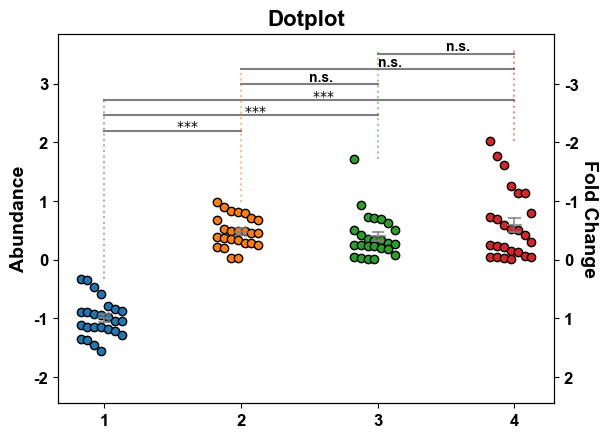

<AxesSubplot:title={'center':'Dotplot'}, ylabel='Abundance'>

In [15]:
stats = {"test" : "Holm-Sidak", 
                          "parametric" : True,
                          "test_kwargs" : {"override" : False,
                                           "labels"   : True,
                                           "alpha"    : 0.05}}
#print(a)
#print(b)
#print(c)
#print(d)
plot_dotplot([a,b,c,d],
             stats =stats,
             foldchange_axis = True,
             foldchange_group = "1")